## to do:

1. use model.eval() instead of model.train(), and see why the model deviates a lot. Shortened evaluation to 40 or 80 perhaps instead of 320.

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 22.8 MB/s 
     |████████████████████████████████| 180 kB 59.6 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 139 kB 58.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=60477d23a45d1a2eabb0dcb418f76d4190cd0e16be15f08a73eefee0245aaf50
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=b7d6c25f1088da5dba0528c97683c6cbad7eaa6920401ba5ec1a9773c33a7e7f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


ref: https://github.com/chaoshangcs/GTS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
!ls

/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
'1. gts-graphbatt-train.ipynb'
'2. gts-graphbatt-benchmarking.ipynb'
'4b. monteCarlo-gts-gaets-benchmarkData-train-evaluate.ipynb'
'4. monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
'5. customWindow-monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
 data
 gts-debug.ipynb
 lib
 LICENSE
 model
 models
 pytorch-geometric-temporal.ipynb
 README.md
 requirements.txt
 runs
 scripts
 train.py
 wandb


In [7]:
import argparse
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

## monte carlo sweep

In [8]:
import os
import re

import torch

from tqdm.notebook import tqdm
import networkx as nx

class DummyTrainArgs():
  def __init__(self, config_filename, use_cpu_only, temperature):
    self.config_filename = config_filename
    self.use_cpu_only = use_cpu_only
    self.temperature = temperature

import argparse
import yaml
from importlib import reload
import model
reload(model)
from model.pytorch.supervisor import GTSSupervisor, GAETSSupervisor
from lib.utils import load_graph_data
import torch

import scripts.eval_baseline_methods

import argparse
import numpy as np
import pandas as pd

from statsmodels.tsa.vector_ar.var_model import VAR

# from lib import utils
from lib.metrics import masked_rmse_np, masked_mape_np, masked_mae_np
from lib.utils import StandardScaler

from tqdm.notebook import tqdm

In [11]:
""" Create Train Dataset """
train_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_81_1")
train_df = train_df.iloc[:2257]
train_df.set_index("Date_Time", inplace=True)
train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5", key="df")

!python -m scripts.generate_training_data_customWindow --output_dir=data/graphbatt/train --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5


Generating training data
x shape:  (2138, 80, 6, 1) , y shape:  (2138, 40, 6, 1)
train x:  (1497, 80, 6, 1) y: (1497, 40, 6, 1)
val x:  (213, 80, 6, 1) y: (213, 40, 6, 1)
test x:  (428, 80, 6, 1) y: (428, 40, 6, 1)


In [ ]:
""" Create Test Dataset """
test_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_82_1")
test_df = test_df.iloc[:2257]
test_df.set_index("Date_Time", inplace=True)
test_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5", key="df")

# create larger portion of test data
!python -m scripts.generate_testing_data_customWindow --output_dir=data/graphbatt/test --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5

Generating testing data
x shape:  (2138, 80, 6, 1) , y shape:  (2138, 40, 6, 1)
train x:  (428, 80, 6, 1) y: (428, 40, 6, 1)
val x:  (213, 80, 6, 1) y: (213, 40, 6, 1)
test x:  (1497, 80, 6, 1) y: (1497, 40, 6, 1)


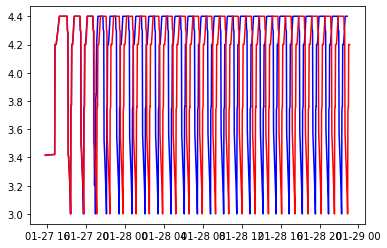

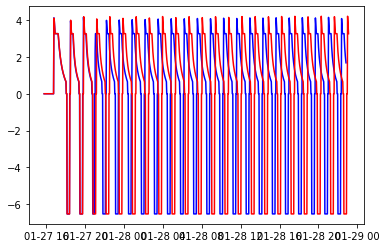

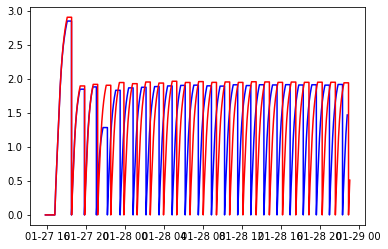

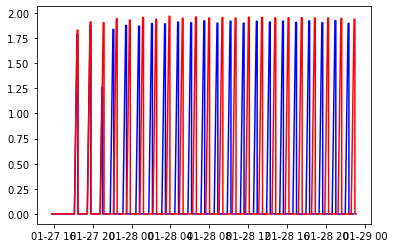

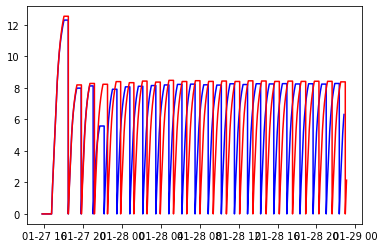

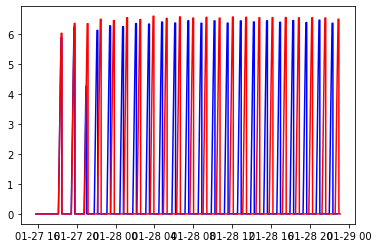

In [ ]:
for col in ["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]:
  plt.plot(train_df[col].iloc[:1000], c="b")
  plt.plot(test_df[col].iloc[:1000], c="r")
  plt.show()

## train model

In [9]:
""" LOAD FROM DIFFERENT FILES """
import numpy as np
from lib.utils import DataLoader

# load test dataset
def create_test_iterator(supervisor, supervisor_config, test_dataset_dir = "data/graphbatt/test"):
  data = {}
  category = 'test'
  cat_data = np.load(os.path.join(test_dataset_dir, category + '.npz'))
  _x = cat_data['x']
  _y = cat_data['y']
  # use scaler from supervisor trained's scaler
  scaler = supervisor.train_scaler
  _x[..., 0] = scaler.transform(_x[..., 0])
  _y[..., 0] = scaler.transform(_y[..., 0])
  test_loader = DataLoader(_x, _y, supervisor_config["data"]["test_batch_size"], shuffle=False)

  return test_loader.get_iterator()

2021-09-30 15:16:51,597 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930151647/
2021-09-30 15:16:53,915 - INFO - Model created


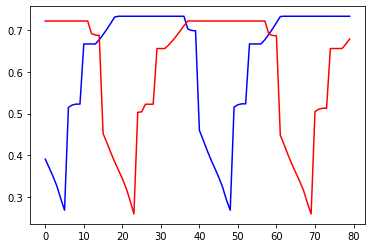

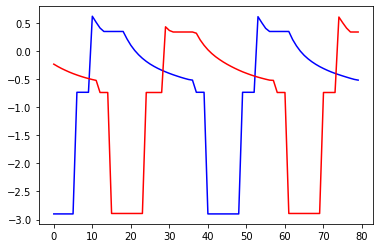

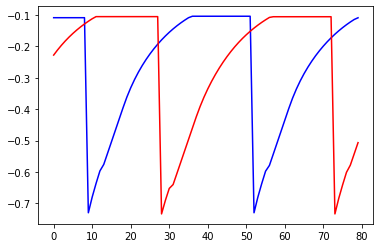

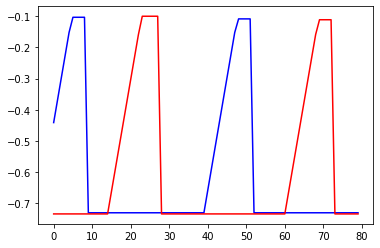

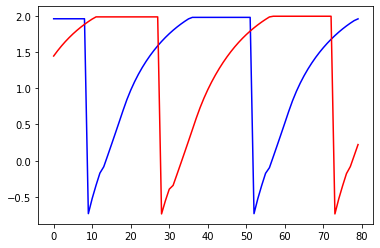

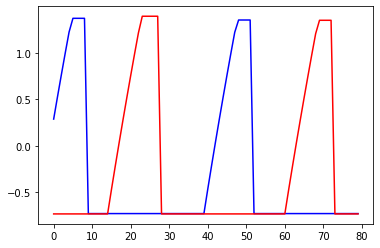

In [10]:
# inspect data
# load model and test dataset
args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
# test_args = DummyTrainArgs(config_filename="data/model/para_graphbatt_test.yaml", use_cpu_only=False, temperature=0.5)
with open(args.config_filename) as f:
    supervisor_config = yaml.load(f)
    save_adj_name = args.config_filename[11:-5]
    supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)

# manual iterator
gts_train_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/train")
_x, _y = list(gts_train_iterator)[0]

# train iterator
_x_train, _y_train = list(supervisor_gts._data["train_loader"].get_iterator())[0]

for i in range(6):
  plt.plot(_x[0, :, i, 0], c="b")
  plt.plot(_x_train[0, :, i, 0], c="r")
  plt.show()

In [18]:
# number of monte carlo iteration
num_mc = 5

In [ ]:
"""
TRAIN AND TEST ON THE SAME FILE
hypothesis: need early stopping i.e. by epoch 13, otherwise model overfits and stops performing well even in test files
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mc_scores = []
for mc_round in tqdm(range(num_mc)):

  # load model and test dataset
  args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
  with open(args.config_filename) as f:
      supervisor_config = yaml.load(f)
      save_adj_name = args.config_filename[11:-5]
      supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gaets.GTS_model.use_curriculum_learning = False
      supervisor_gaets.train()
      supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gts.GTS_model.use_curriculum_learning = False
      supervisor_gts.train()


  # get largest epoch
  files = os.listdir("models/GTS")
  largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  files = os.listdir("models/GAETS")
  largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

  # Load Model
  supervisor_gts._epoch_num = largestGTSEpoch
  supervisor_gts.load_model()
  supervisor_gaets._epoch_num = largestGAETSEpoch
  supervisor_gaets.load_model()
  label = "with_regularization"
  temp_gts = supervisor_gts.temperature
  temp_gaets = supervisor_gaets.temperature
  gumbel_soft = True
  batches_seen = 1

  # # get test data from unseen dataset
  gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
  gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")
  
  """
  COMPARE PERFORMANCE
  """
  # for each batch
  var_rmses = []
  var_mapes = []
  var_maes = []
  gts_rmses = []
  gts_mapes = []
  gts_maes = []
  gaets_rmses = []
  gaets_mapes = []
  gaets_maes = []

  # for each batch
  for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
    """ GAETS """
    x, y = supervisor_gaets._prepare_data(_x, _y)
    # supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
    supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
    output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      gaets_prediction = output[:, i, :].cpu().numpy()
      gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gaets_rmse) < np.float("inf"):
        gaets_rmses.append(gaets_rmse)
      if abs(gaets_mape) < np.float("inf"):
        gaets_mapes.append(gaets_mape)
      if abs(gaets_mae) < np.float("inf"):
        gaets_maes.append(gaets_mae)

    """ VAR """
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      input = x[:, i, :].cpu().numpy()

      # fit VAR model on input
      var_model = VAR(input)
      # TODO: choose best lag
      var_result = var_model.fit(31)
      var_prediction = var_result.forecast(input, 40)

      var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
      var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
      var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

      # keep track
      if abs(var_rmse) < np.float("inf"):
        var_rmses.append(var_rmse)
      if abs(var_mape) < np.float("inf"):
        var_mapes.append(var_mape)
      if abs(var_mae) < np.float("inf"):
        var_maes.append(var_mae)


  """ GTS """
  for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
    x, y = supervisor_gts._prepare_data(_x, _y)
    # supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
    supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
    output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      gts_prediction = output[:, i, :].cpu().numpy()
      gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gts_rmse) < np.float("inf"):
        gts_rmses.append(gts_rmse)
      if abs(gts_mape) < np.float("inf"):
        gts_mapes.append(gts_mape)
      if abs(gts_mae) < np.float("inf"):
        gts_maes.append(gts_mae)


  """
  get score
  """
  scoreMedianDict = {
    "GAETS": {
        "RMSE": np.median(gaets_rmses), 
        "MAPE": np.median(gaets_mapes), 
        "MAE": np.median(gaets_maes), 
        "RMS data points": len(gaets_rmses), 
        "MAPE data points": len(gaets_mapes), 
        "MAE data points": len(gaets_maes),
        "Best Epoch": largestGAETSEpoch
    },
    "GTS": {
        "RMSE": np.median(gts_rmses), 
        "MAPE": np.median(gts_mapes), 
        "MAE": np.median(gts_maes), 
        "RMS data points": len(gts_rmses), 
        "MAPE data points": len(gts_mapes), 
        "MAE data points": len(gts_maes),
        "Best Epoch": largestGTSEpoch
    },
    "VAR": {
        "RMSE": np.median(var_rmses), 
        "MAPE": np.median(var_mapes), 
        "MAE": np.median(var_maes), 
        "RMS data points": len(var_rmses), 
        "MAPE data points": len(var_mapes), 
        "MAE data points": len(var_maes),
        "Best Epoch": -1
    },
  }
  print(mc_round, scoreMedianDict)
  mc_scores.append(scoreMedianDict)

  # remove model
  !rm models/GTS/*
  !rm models/GAETS/*

  0%|          | 0/5 [00:00<?, ?it/s]

2021-09-27 17:00:05,283 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927170005/
2021-09-27 17:00:05,283 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927170005/
2021-09-27 17:00:05,283 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927170005/
2021-09-27 17:00:05,283 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927170005/
2021-09-27 17:00:05,463 - INFO - Model created
2021-09-27 17:00:05,463 - INFO - Model created
2021-09-27 17:00:05,463 - INFO - Model created
2021-09-27 17:00:05,463 - INFO - Model created


2021-09-27 17:00:15,952 - INFO - Start training ...
2021-09-27 17:00:15,952 - INFO - Start training ...
2021-09-27 17:00:15,952 - INFO - Start training ...
2021-09-27 17:00:15,952 - INFO - Start training ...
2021-09-27 17:00:15,975 - INFO - num_batches:24
2021-09-27 17:00:15,975 - INFO - num_batches:24
2021-09-27 17:00:15,975 - INFO - num_batches:24
2021-09-27 17:00:15,975 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 17:00:16,765 - INFO - Total trainable parameters 3072347
2021-09-27 17:00:16,765 - INFO - Total trainable parameters 3072347
2021-09-27 17:00:16,765 - INFO - Total trainable parameters 3072347
2021-09-27 17:00:16,765 - INFO - Total trainable parameters 3072347
2021-09-27 17:00:38,369 - INFO - epoch complete
2021-09-27 17:00:38,369 - INFO - epoch complete
2021-09-27 17:00:38,369 - INFO - epoch complete
2021-09-27 17:00:38,369 - INFO - epoch complete
2021-09-27 17:00:38,384 - INFO - evaluating now!
2021-09-27 17:00:38,384 - INFO - evaluating now!
2021-09-27 17:00:38,38

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 17:00:39,764 - INFO - Epoch [0/50] (24) train_mae: 3.6563, val_mae: 3.1444
2021-09-27 17:00:39,764 - INFO - Epoch [0/50] (24) train_mae: 3.6563, val_mae: 3.1444
2021-09-27 17:00:39,764 - INFO - Epoch [0/50] (24) train_mae: 3.6563, val_mae: 3.1444
2021-09-27 17:00:39,764 - INFO - Epoch [0/50] (24) train_mae: 3.6563, val_mae: 3.1444
2021-09-27 17:00:39,871 - INFO - Saved model at 0
2021-09-27 17:00:39,871 - INFO - Saved model at 0
2021-09-27 17:00:39,871 - INFO - Saved model at 0
2021-09-27 17:00:39,871 - INFO - Saved model at 0
2021-09-27 17:00:39,898 - INFO - Val loss decrease from inf to 3.1444, saving to models/GAETS/epo0.tar
2021-09-27 17:00:39,898 - INFO - Val loss decrease from inf to 3.1444, saving to models/GAETS/epo0.tar
2021-09-27 17:00:39,898 - INFO - Val loss decrease from inf to 3.1444, saving to models/GAETS/epo0.tar
2021-09-27 17:00:39,898 - INFO - Val loss decrease from inf to 3.1444, saving to models/GAETS/epo0.tar
Num of epoch: 1
2021-09-27 17:01:01,598 - IN

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 17:02:31,981 - INFO - epoch complete
2021-09-27 17:02:31,981 - INFO - epoch complete
2021-09-27 17:02:31,981 - INFO - epoch complete
2021-09-27 17:02:31,981 - INFO - epoch complete
2021-09-27 17:02:31,996 - INFO - evaluating now!
2021-09-27 17:02:31,996 - INFO - evaluating now!
2021-09-27 17:02:31,996 - INFO - evaluating now!
2021-09-27 17:02:31,996 - INFO - evaluating now!
2021-09-27 17:02:33,336 - INFO - Epoch [5/50] (144) train_mae: 0.6714, val_mae: 0.6155
2021-09-27 17:02:33,336 - INFO - Epoch [5/50] (144) train_mae: 0.6714, val_mae: 0.6155
2021-09-27 17:02:33,336 - INFO - Epoch [5/50] (144) train_mae: 0.6714, val_mae: 0.6155
2021-09-27 17:02:33,336 - INFO - Epoch [5/50] (144) train_mae: 0.6714, val_mae: 0.6155
2021-09-27 17:02:33,443 - INFO - Saved model at 5
2021-09-27 17:02:33,443 - INFO - Saved model at 5
2021-09-27 17:02:33,443 - INFO - Saved model at 5
2021-09-27 17:02:33,443 - INFO - Saved model at 5
2021-09-27 17:02:33,461 - INFO - Val loss decrease from 0.9050 t

testing loss,0.36655
training loss,0.18333
validation loss,0.25154


testing loss,█▃▁▂▁▃▁▂▁▁
training loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


2021-09-27 17:19:01,289 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927171901/
2021-09-27 17:19:01,289 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927171901/
2021-09-27 17:19:01,289 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927171901/
2021-09-27 17:19:01,289 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927171901/
2021-09-27 17:19:01,289 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927171901/
2021-09-27 17:19:01,434 - INFO - Model created
2021-09-27 17:19:01,434 - INFO - Model created
2021-09-27 17:19:01,434 - INFO - Model created
2021-09-27 17:19:01,434 - INFO - Model created
2021-09-27 17:19:01,434 - INFO - Model created


2021-09-27 17:19:09,482 - INFO - Start training ...
2021-09-27 17:19:09,482 - INFO - Start training ...
2021-09-27 17:19:09,482 - INFO - Start training ...
2021-09-27 17:19:09,482 - INFO - Start training ...
2021-09-27 17:19:09,482 - INFO - Start training ...
2021-09-27 17:19:09,503 - INFO - num_batches:24
2021-09-27 17:19:09,503 - INFO - num_batches:24
2021-09-27 17:19:09,503 - INFO - num_batches:24
2021-09-27 17:19:09,503 - INFO - num_batches:24
2021-09-27 17:19:09,503 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 17:19:10,016 - INFO - Total trainable parameters 2596563
2021-09-27 17:19:10,016 - INFO - Total trainable parameters 2596563
2021-09-27 17:19:10,016 - INFO - Total trainable parameters 2596563
2021-09-27 17:19:10,016 - INFO - Total trainable parameters 2596563
2021-09-27 17:19:10,016 - INFO - Total trainable parameters 2596563
2021-09-27 17:19:28,954 - INFO - epoch complete
2021-09-27 17:19:28,954 - INFO - epoch complete
2021-09-27 17:19:28,954 - INFO - epoch complete


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 17:19:30,234 - INFO - Epoch [0/50] (24) train_mae: 2.2388, val_mae: 2.5511
2021-09-27 17:19:30,234 - INFO - Epoch [0/50] (24) train_mae: 2.2388, val_mae: 2.5511
2021-09-27 17:19:30,234 - INFO - Epoch [0/50] (24) train_mae: 2.2388, val_mae: 2.5511
2021-09-27 17:19:30,234 - INFO - Epoch [0/50] (24) train_mae: 2.2388, val_mae: 2.5511
2021-09-27 17:19:30,234 - INFO - Epoch [0/50] (24) train_mae: 2.2388, val_mae: 2.5511
2021-09-27 17:19:30,329 - INFO - Saved model at 0
2021-09-27 17:19:30,329 - INFO - Saved model at 0
2021-09-27 17:19:30,329 - INFO - Saved model at 0
2021-09-27 17:19:30,329 - INFO - Saved model at 0
2021-09-27 17:19:30,329 - INFO - Saved model at 0
2021-09-27 17:19:30,352 - INFO - Val loss decrease from inf to 2.5511, saving to models/GTS/epo0.tar
2021-09-27 17:19:30,352 - INFO - Val loss decrease from inf to 2.5511, saving to models/GTS/epo0.tar
2021-09-27 17:19:30,352 - INFO - Val loss decrease from inf to 2.5511, saving to models/GTS/epo0.tar
2021-09-27 17:19:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 17:21:14,869 - INFO - epoch complete
2021-09-27 17:21:14,869 - INFO - epoch complete
2021-09-27 17:21:14,869 - INFO - epoch complete
2021-09-27 17:21:14,869 - INFO - epoch complete
2021-09-27 17:21:14,869 - INFO - epoch complete
2021-09-27 17:21:14,882 - INFO - evaluating now!
2021-09-27 17:21:14,882 - INFO - evaluating now!
2021-09-27 17:21:14,882 - INFO - evaluating now!
2021-09-27 17:21:14,882 - INFO - evaluating now!
2021-09-27 17:21:14,882 - INFO - evaluating now!
2021-09-27 17:21:16,190 - INFO - Epoch [5/50] (144) train_mae: 1.1318, val_mae: 1.6959
2021-09-27 17:21:16,190 - INFO - Epoch [5/50] (144) train_mae: 1.1318, val_mae: 1.6959
2021-09-27 17:21:16,190 - INFO - Epoch [5/50] (144) train_mae: 1.1318, val_mae: 1.6959
2021-09-27 17:21:16,190 - INFO - Epoch [5/50] (144) train_mae: 1.1318, val_mae: 1.6959
2021-09-27 17:21:16,190 - INFO - Epoch [5/50] (144) train_mae: 1.1318, val_mae: 1.6959
2021-09-27 17:21:16,282 - INFO - Saved model at 5
2021-09-27 17:21:16,282 - INFO

testing loss,0.95588
training loss,0.19326
validation loss,0.87341


testing loss,█▃▂▅▁▁▂▁▁▂
training loss,█▇▆▅▄▄▄▃▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▅▄▃▄▂▂▁▂▁▁▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂


best GTS epoch: 45 and GAETS epoch: 48
2021-09-27 17:37:53,451 - INFO - Loaded model at 45
2021-09-27 17:37:53,451 - INFO - Loaded model at 45
2021-09-27 17:37:53,451 - INFO - Loaded model at 45
2021-09-27 17:37:53,451 - INFO - Loaded model at 45
2021-09-27 17:37:53,451 - INFO - Loaded model at 45
2021-09-27 17:37:53,522 - INFO - Loaded model at 48
2021-09-27 17:37:53,522 - INFO - Loaded model at 48
2021-09-27 17:37:53,522 - INFO - Loaded model at 48
2021-09-27 17:37:53,522 - INFO - Loaded model at 48
2021-09-27 17:37:53,522 - INFO - Loaded model at 48


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0 {'GAETS': {'RMSE': 0.082770176, 'MAPE': 0.097120896, 'MAE': 0.032682408, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'GTS': {'RMSE': 0.09424019, 'MAPE': 0.10780409, 'MAE': 0.03545101, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 45}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
2021-09-27 17:38:35,386 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927173835/
2021-09-27 17:38:35,386 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927173835/
2021-09-27 17:38:35,386 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927173835/
2021-09-27 17:38:35,386 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927173835/
2021-09-27 17:38:35,386 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.

2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,047 - INFO - Start training ...
2021-09-27 17:38:44,073 - INFO - num_batches:24
2021-09-27 17:38:44,073 - INFO - num_batches:24
2021-09-27 17:38:44,073 - INFO - num_batches:24
2021-09-27 17:38:44,073 - INFO - num_batches:24
2021-09-27 17:38:44,073 - INFO - num_batches:24
2021-09-27 17:38:44,073 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 17:38:44,630 - INFO - Total trainable parameters 3072347
2021-09-27 17:38:44,630 - INFO - Total trainable parameters 3072347
2021-09-27 17:38:44,630 - INFO - Total trainable parameters 3072347
2021-09-27 17:38:44,630 - INFO - Total trainable parameters 3072347
2021-09-27 17:38:44,630 - INFO - Total trainable parameters 3072347
2021-09-27 17:38:44,630 - INFO - Total train

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:07,752 - INFO - Epoch [0/50] (24) train_mae: 3.6149, val_mae: 3.2220
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,102 - INFO - Saved model at 0
2021-09-27 17:39:08,139 - INFO - Val loss decrease from inf to 3.2220, saving to models/GAETS/epo0.tar
2021-09-27 17:39:08,139 - INFO - Val loss decrease from inf to 3.2220, saving to 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Num of epoch: 5
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,917 - INFO - epoch complete
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:02,946 - INFO - evaluating now!
2021-09-27 17:41:04,261 - INFO - Epoch [5/50] (144) train_mae: 0.8969, val_mae: 0.8418
2021-09-27 17:41:04,261 - INFO - Epoch [5/50] (144) train_mae: 0.8969, val_mae: 0.8418
2021-09-27 17:41:04,261 - INFO - Epoch [5/50] (144) train_mae: 0.8969, val_mae: 0.8418
2021-09-27 17:41:04,261 - INFO - Epoch [5/50] (144) train_mae: 0.8969, val_mae: 0.8418
2021-09-27 17:41:04,261 - INFO - Epoch [5/50] (144) tr

testing loss,0.34598
training loss,0.1892
validation loss,0.22682


testing loss,█▂▂▁▁▂▁▂▁▁
training loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▅▄▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,009 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927175805/
2021-09-27 17:58:06,178 - INFO - Model created
2021-09-27 17:58:06,178 - INFO - Model created
2021-09-27 17:58:06,178 - INFO - Model created
2021-09-27 17:58:06,178 - INFO - Model created
2021-09-27 17:58:06,178 - INFO - Model created
2021-09-27 17:58:06,178 - INFO - Model creat

2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,457 - INFO - Start training ...
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
2021-09-27 17:58:14,504 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 17:58:15,119 - INFO - Total trainable parameters 2596563
2021-09-27 17:58:15,119 - INFO - Total trainable parameters 2596563
2021-09-27 17:58:15,119 - INFO - Total trainable parameters 2596563
2021-09-27 17:58:15,119 - INFO - Total trainable parameters 2596563
2021-09-27 1

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,334 - INFO - Epoch [0/50] (24) train_mae: 2.2610, val_mae: 2.1628
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,409 - INFO - Saved model at 0
2021-09-27 17:58:36,425 - INFO - Val loss decrea

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,182 - INFO - epoch complete
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:26,223 - INFO - evaluating now!
2021-09-27 18:00:27,525 - INFO - Epoch [5/50] (144) train_mae: 0.9739, val_mae: 1.4718
2021-09-27 18:00:27,525 - INFO - Epoch [5/50] (144) train_mae: 0.9739, val_mae: 1.4718
2021-09-27 18:00:27,525 - INFO - Epoch [5/50] (144) train_mae: 0.9739, val_mae: 1.4718
2021-09-27 18:00:27,525 - INFO - Epoch [5/50] (144) train_ma

testing loss,0.79821
training loss,0.14258
validation loss,0.68436


testing loss,█▄▂▁▁▂▁▁▁▁
training loss,█▆▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▇▇▅▄▄▄▂▂▂▂▁▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁


best GTS epoch: 37 and GAETS epoch: 30
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,691 - INFO - Loaded model at 37
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30
2021-09-27 18:16:46,773 - INFO - Loaded model at 30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

1 {'GAETS': {'RMSE': 0.11047426, 'MAPE': 0.10396364, 'MAE': 0.04294454, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 30}, 'GTS': {'RMSE': 0.13020022, 'MAPE': 0.13256466, 'MAE': 0.04110959, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
2021-09-27 18:17:28,440 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927181728/
2021-09-27 18:17:28,440 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927181728/
2021-09-27 18:17:28,440 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927181728/
2021-09-27 18:17:28,440 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927181728/
2021-09-27 18:17:28,440 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005

2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,025 - INFO - Start training ...
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
2021-09-27 18:17:37,061 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 18:17:37,628 - INFO - Total trainable parameters 3072347
2021-09-27 18:17:37,628 - INFO - Total trainable parameters 3072347
2021-09-27 18:17:37,628 - INFO - Total trainable

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,292 - INFO - Epoch [0/50] (24) train_mae: 3.8573, val_mae: 3.2082
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 18:17:59,424 - INFO - Saved model at 0
2021-09-27 1

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,019 - INFO - Saved model at 4
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.9922, saving to models/GAETS/epo4.tar
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.9922, saving to models/GAETS/epo4.tar
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.9922, saving to models/GAETS/epo4.tar
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.9922, saving to models/GAETS/epo4.tar
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.9922, saving to models/GAETS/epo4.tar
2021-09-27 18:19:32,038 - INFO - Val loss decrease from 2.1800 to 1.99

testing loss,1.02962
training loss,0.4299
validation loss,0.86118


testing loss,█▅▂▂▁▁▁▁▁▃
training loss,█▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▅▄▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂


2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,412 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927183616/
2021-09-27 18:36:16,610 - INFO - Model created
2021-09-27 18:36:16,610 - 

2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,784 - INFO - Start training ...
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
2021-09-27 18:36:24,824 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 18:36:25,476 - INFO - Total trainable parameters 2596563
2021-09-27 18:36

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,220 - INFO - Epoch [0/50] (24) train_mae: 2.1887, val_mae: 2.2108
2021-09-27 18:36:47,371 - INFO - Saved model at 0
2021-09-27 18:36:47,371 - INFO - Saved model at 0
2021-09-27 18:36:47,371 - INFO - Saved model at 0
2021-09-27 18:36:47,371 - INFO - Saved model at 0
2021-09-27 18:36:47,371 - 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 18:38:17,244 - INFO - Val loss decrease from 1.8252 to 1.7527, saving to models/GTS/epo4.tar
2021-09-27 18:38:17,244 - INFO - Val loss decrease from 1.8252 to 1.7527, saving to models/GTS/epo4.tar
2021-09-27 18:38:17,244 - INFO - Val loss decrease from 1.8252 to 1.7527, saving to models/GTS/epo4.tar
2021-09-27 18:38:17,244 - INFO - Val loss decrease from 1.8252 to 1.7527, saving to models/GTS/epo4.tar
Num of epoch: 5
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,936 - INFO - epoch complete
2021-09-27 18:38:37,999 - INFO - evaluating now!
2021-09-27 18:38:37,999 - INFO - evaluating now!
2021-09-27 18:38:37,999 - INFO - evalu

testing loss,0.77727
training loss,0.17835
validation loss,0.65392


testing loss,█▃▃▂▁▁▂▁▁▁
training loss,█▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▇▆▅▄▄▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


best GTS epoch: 49 and GAETS epoch: 47
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:12,971 - INFO - Loaded model at 49
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47
2021-09-27 18:55:13,078 - INFO - Loaded model at 47


0it [00:00, ?it/s]

0it [00:00, ?it/s]

2 {'GAETS': {'RMSE': 0.08979202, 'MAPE': 0.10050458, 'MAE': 0.035726428, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 47}, 'GTS': {'RMSE': 0.14195114, 'MAPE': 0.14598447, 'MAE': 0.047258776, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
2021-09-27 18:55:55,664 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927185555/
2021-09-27 18:55:55,664 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927185555/
2021-09-27 18:55:55,664 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927185555/
2021-09-27 18:55:55,664 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927185555/
2021-09-27 18:55:55,664 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.0

2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,867 - INFO - Start training ...
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24
2021-09-27 18:56:03,891 - INFO - num_batches:24


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,133 - INFO - Epoch [0/50] (24) train_mae: 3.5260, val_mae: 2.9255
2021-09-27 18:56:27,306 - INFO - Saved model at 0
2021-09-27 18:56:27,306 - INFO - Saved model at 0
2021-09-27 18:56:27,306 - INFO - Saved m

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 18:58:05,600 - INFO - Saved model at 4
2021-09-27 18:58:05,600 - INFO - Saved model at 4
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease from 0.8702 to 0.6652, saving to models/GAETS/epo4.tar
2021-09-27 18:58:05,639 - INFO - Val loss decrease f

testing loss,0.38768
training loss,0.15281
validation loss,0.26539


testing loss,█▄▃▁▂▁▁▁▁▂
training loss,█▆▄▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▄▃▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927191450/
2021-09-27 19:14:50,441 - INFO - Log directory: data/model/GTS_DR_2_h_40_

2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,637 - INFO - Start training ...
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches:24
2021-09-27 19:14:58,681 - INFO - num_batches

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:19,348 - INFO - evaluating now!
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-09-27 19:15:21,117 - INFO - Epoch [0/50] (24) train_mae: 2.3893, val_mae: 2.7691
2021-0

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,159 - INFO - Saved model at 4
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving to models/GTS/epo4.tar
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving to models/GTS/epo4.tar
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving to models/GTS/epo4.tar
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving to models/GTS/epo4.tar
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving to models/GTS/epo4.tar
2021-09-27 19:16:49,205 - INFO - Val loss decrease from 2.1570 to 1.8528, saving

testing loss,0.78434
training loss,0.17221
validation loss,0.67342


testing loss,█▄▂▂▂▂▁▁▁▁
training loss,██▇▅▄▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▇▅▄▄▄▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁


best GTS epoch: 49 and GAETS epoch: 41
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,271 - INFO - Loaded model at 49
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 - INFO - Loaded model at 41
2021-09-27 19:33:36,372 -

0it [00:00, ?it/s]

0it [00:00, ?it/s]

3 {'GAETS': {'RMSE': 0.10913119, 'MAPE': 0.15479904, 'MAE': 0.04602757, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 41}, 'GTS': {'RMSE': 0.09579709, 'MAPE': 0.122228965, 'MAE': 0.040918387, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
2021-09-27 19:34:17,435 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927193417/
2021-09-27 19:34:17,435 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927193417/
2021-09-27 19:34:17,435 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927193417/
2021-09-27 19:34:17,435 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927193417/
2021-09-27 19:34:17,435 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.0

2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,078 - INFO - Start training ...
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_batches:24
2021-09-27 19:34:26,162 - INFO - num_bat

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) train_mae: 3.6689, val_mae: 3.1464
2021-09-27 19:34:48,779 - INFO - Epoch [0/50] (24) tra

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 19:36:17,276 - INFO - Saved model at 4
2021-09-27 19:36:17,276 - INFO - Saved model at 4
2021-09-27 19:36:17,276 - INFO - Saved model at 4
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
2021-09-27 19:36:17,332 - INFO - Val loss decrease from 1.0503 to 0.9819, saving to models/GAETS/epo4.tar
20

testing loss,0.42826
training loss,0.27274
validation loss,0.30315


testing loss,█▂▃▂▂▂▁▁▂▂
training loss,█▆▅▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▄▃▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927195254/
2021-09-27 19:52:54,367 - INFO - Log directory: data/model/GTS_DR_2_h_40_

2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,404 - INFO - Start training ...
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num_batches:24
2021-09-27 19:53:02,448 - INFO - num

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) train_mae: 2.3537, val_mae: 2.2232
2021-09-27 19:53:23,789 - INFO - Epoch [0/50] (24) tra

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,047 - INFO - Saved model at 4
2021-09-27 19:54:49,107 - INFO - Val loss decrease from 1.7811 to 1.6933, saving to models/GTS/epo4.tar
2021-09-27 19:54:49,107 - INFO - Val loss decrease from 1.7811 to 1.6933, saving to models/GTS/epo4.tar
2021-09-27 19:54:49,107 - INFO - Val loss decrease from 1.7811 to 1.6933, saving to models/GTS/epo4.tar
2021-09-27 19:54:49,107 - INFO - Val l

testing loss,0.86905
training loss,0.17829
validation loss,0.77453


testing loss,█▃▂▂▁▂▁▁▁▂
training loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


best GTS epoch: 48 and GAETS epoch: 37
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,089 - INFO - Loaded model at 48
2021-09-27 20:11:20,216 - INFO - Loaded model at 37
2021-09-27 20:11:20,216 - INFO - Loaded model at 37
2021-09-27 20:11:20,216 - INFO - Loaded model at 37
2021-09-27 20:11:20,216 - INFO - Loaded model at 37
2021-09-27 20:11:20,216 - INFO - Loaded model at 37
2021-09-27 20:11:20,216 -

0it [00:00, ?it/s]

0it [00:00, ?it/s]

4 {'GAETS': {'RMSE': 0.12081312, 'MAPE': 0.10371947, 'MAE': 0.038727574, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'GTS': {'RMSE': 0.11472775, 'MAPE': 0.117630266, 'MAE': 0.039228816, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}


In [48]:
#
mc_scores = [
{'GAETS': {'RMSE': 0.076583415, 'MAPE': 0.114658184, 'MAE': 0.037458606, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 35}, 'GTS': {'RMSE': 0.15764831, 'MAPE': 0.14302702, 'MAE': 0.044160694, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 43}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.1654805, 'MAPE': 0.15542635, 'MAE': 0.05086104, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'GTS': {'RMSE': 0.14906015, 'MAPE': 0.13430354, 'MAE': 0.048460353, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 41}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.082770176, 'MAPE': 0.097120896, 'MAE': 0.032682408, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'GTS': {'RMSE': 0.09424019, 'MAPE': 0.10780409, 'MAE': 0.03545101, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 45}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.11047426, 'MAPE': 0.10396364, 'MAE': 0.04294454, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 30}, 'GTS': {'RMSE': 0.13020022, 'MAPE': 0.13256466, 'MAE': 0.04110959, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.08979202, 'MAPE': 0.10050458, 'MAE': 0.035726428, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 47}, 'GTS': {'RMSE': 0.14195114, 'MAPE': 0.14598447, 'MAE': 0.047258776, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.10913119, 'MAPE': 0.15479904, 'MAE': 0.04602757, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 41}, 'GTS': {'RMSE': 0.09579709, 'MAPE': 0.122228965, 'MAE': 0.040918387, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.12081312, 'MAPE': 0.10371947, 'MAE': 0.038727574, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'GTS': {'RMSE': 0.11472775, 'MAPE': 0.117630266, 'MAE': 0.039228816, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'VAR': {'RMSE': 0.01210054, 'MAPE': 0.026709542, 'MAE': 0.0071307914, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
]

## fix VAR training 

train on train_df only

  0%|          | 0/1 [00:00<?, ?it/s]

2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0930155953/
2021-09-30 15:59:53,025 - INFO - Log directory: data/model/GTS_DR_2_h_40_

0it [00:00, ?it/s]

0 {'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
0


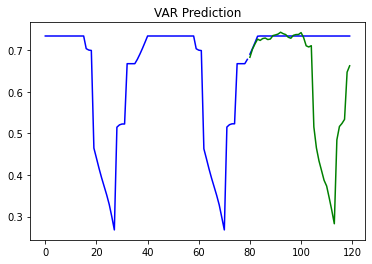

1


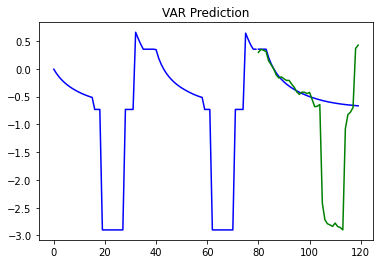

2


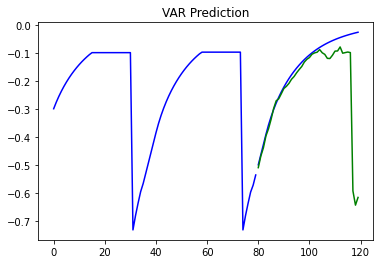

3


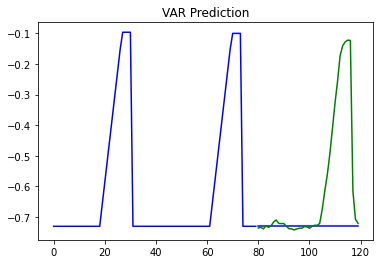

4


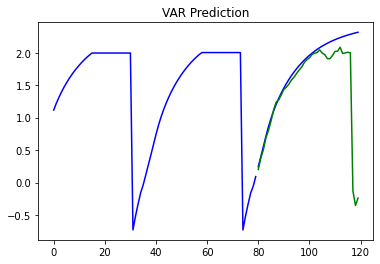

5


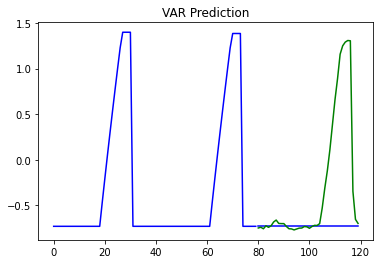

In [62]:
"""
TRAIN VAR on WHOLE TRAIN_DF
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

var_mc_scores = []
for mc_round in tqdm(range(1)):

  # load model and test dataset
  args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
  with open(args.config_filename) as f:
      supervisor_config = yaml.load(f)
      save_adj_name = args.config_filename[11:-5]
      supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      # train VAR
      scaler = supervisor_gts.train_scaler
      data = scaler.transform(train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].values)
      var_model = VAR(data)
      # TODO: choose best lag
      var_result = var_model.fit(31)

  # get test data from unseen dataset
  gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
  
  """
  COMPARE PERFORMANCE
  """
  # for each batch
  var_rmses = []
  var_mapes = []
  var_maes = []

  # for each batch
  for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
    x, y = supervisor_gts._prepare_data(_x, _y)
    """ VAR """
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      input = x[:, i, :].cpu().numpy()
      var_prediction = var_result.forecast(input, 40)

      var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
      var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
      var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

      # keep track
      if abs(var_rmse) < np.float("inf"):
        var_rmses.append(var_rmse)
      if abs(var_mape) < np.float("inf"):
        var_mapes.append(var_mape)
      if abs(var_mae) < np.float("inf"):
        var_maes.append(var_mae)

  """
  get score
  """
  varScoreMedianDict = {
    "VAR": {
        "RMSE": np.median(var_rmses), 
        "MAPE": np.median(var_mapes), 
        "MAE": np.median(var_maes), 
        "RMS data points": len(var_rmses), 
        "MAPE data points": len(var_mapes), 
        "MAE data points": len(var_maes),
        "Best Epoch": -1
    },
  }
  print(mc_round, varScoreMedianDict)
  var_mc_scores.append(varScoreMedianDict)

# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()


In [56]:
mc_scores = [
{'GAETS': {'RMSE': 0.076583415, 'MAPE': 0.114658184, 'MAE': 0.037458606, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 35}, 'GTS': {'RMSE': 0.15764831, 'MAPE': 0.14302702, 'MAE': 0.044160694, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 43}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.1654805, 'MAPE': 0.15542635, 'MAE': 0.05086104, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'GTS': {'RMSE': 0.14906015, 'MAPE': 0.13430354, 'MAE': 0.048460353, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 41}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.082770176, 'MAPE': 0.097120896, 'MAE': 0.032682408, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'GTS': {'RMSE': 0.09424019, 'MAPE': 0.10780409, 'MAE': 0.03545101, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 45}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.11047426, 'MAPE': 0.10396364, 'MAE': 0.04294454, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 30}, 'GTS': {'RMSE': 0.13020022, 'MAPE': 0.13256466, 'MAE': 0.04110959, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.08979202, 'MAPE': 0.10050458, 'MAE': 0.035726428, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 47}, 'GTS': {'RMSE': 0.14195114, 'MAPE': 0.14598447, 'MAE': 0.047258776, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.10913119, 'MAPE': 0.15479904, 'MAE': 0.04602757, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 41}, 'GTS': {'RMSE': 0.09579709, 'MAPE': 0.122228965, 'MAE': 0.040918387, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 49}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}},
{'GAETS': {'RMSE': 0.12081312, 'MAPE': 0.10371947, 'MAE': 0.038727574, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 37}, 'GTS': {'RMSE': 0.11472775, 'MAPE': 0.117630266, 'MAE': 0.039228816, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': 48}, 'VAR': {'RMSE': 0.07718654, 'MAPE': 0.11132919, 'MAE': 0.041038305, 'RMS data points': 1536, 'MAPE data points': 1536, 'MAE data points': 1536, 'Best Epoch': -1}}
]

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
""" Score Dataframe """

# create dataframe
mc_scores_df = None
for i, scoreMedianDict in enumerate(mc_scores):
  temp = pd.DataFrame(scoreMedianDict).T
  temp["MC Count"] = i
  if mc_scores_df is None:
    mc_scores_df = temp
  else:
    mc_scores_df = pd.concat([mc_scores_df, temp])

mc_scores_df

,RMSE,MAPE,MAE,RMS data points,MAPE data points,MAE data points,Best Epoch,MC Count
GAETS,0.076583,0.114658,0.037459,1536.0,1536.0,1536.0,35.0,0
GTS,0.157648,0.143027,0.044161,1536.0,1536.0,1536.0,43.0,0
VAR,0.077187,0.111329,0.041038,1536.0,1536.0,1536.0,-1.0,0
GAETS,0.165481,0.155426,0.050861,1536.0,1536.0,1536.0,48.0,1
GTS,0.149060,0.134304,0.048460,1536.0,1536.0,1536.0,41.0,1
VAR,0.077187,0.111329,0.041038,1536.0,1536.0,1536.0,-1.0,1
GAETS,0.082770,0.097121,0.032682,1536.0,1536.0,1536.0,48.0,2
GTS,0.094240,0.107804,0.035451,1536.0,1536.0,1536.0,45.0,2
VAR,0.077187,0.111329,0.041038,1536.0,1536.0,1536.0,-1.0,2
GAETS,0.110474,0.103964,0.042945,1536.0,1536.0,1536.0,30.0,3


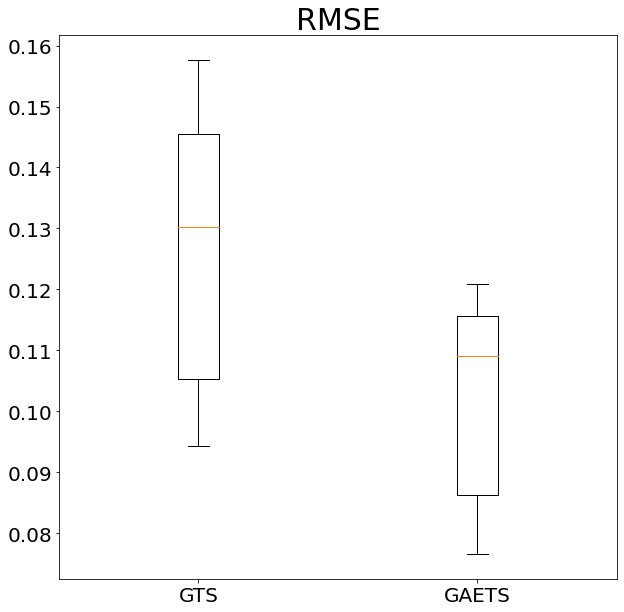

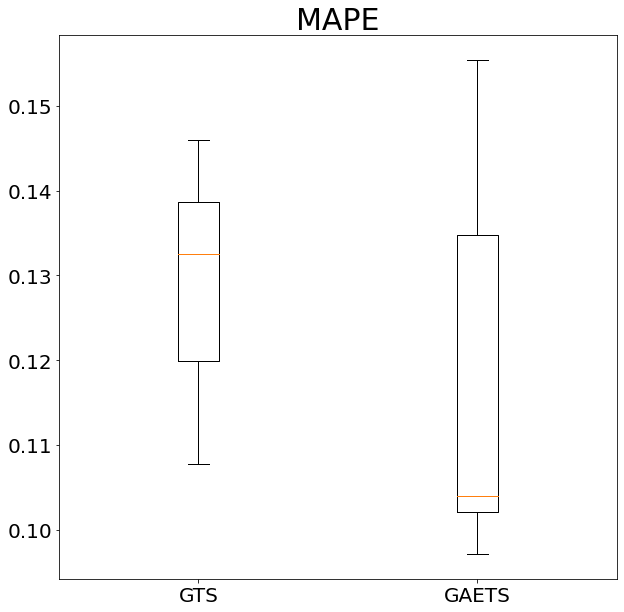

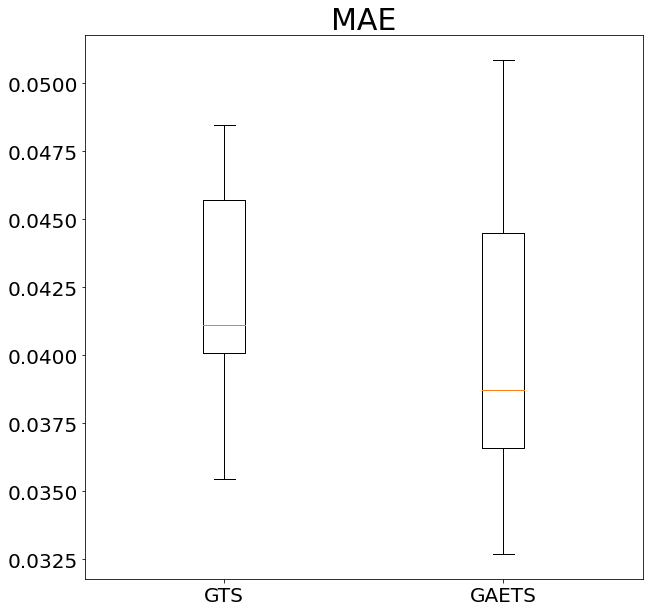

In [59]:
""" Score Visualisation """

score_ticks = ["RMSE", "MAPE", "MAE"]
# list_models = ["VAR", "GTS", "GAETS"]
list_models = ["GTS", "GAETS"]

for score_name in score_ticks:

  plt.figure(figsize=(10, 10))
  plt.title(score_name, fontsize=30)
  scoreDF = mc_scores_df[[score_name]]
  for i, model_name in enumerate(list_models):
    score_value = scoreDF[scoreDF.index == model_name].values
    plt.boxplot(score_value, positions=[i], showfliers=False)
  plt.xticks(range(len(list_models)), list_models, fontsize=20)
  plt.yticks(fontsize=20)
  plt.plot()
  plt.show()

  print("")

best GTS epoch: 41 and GAETS epoch: 48
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,662 - INFO - Loaded model at 41
2021-09-27 16:54:46,714 - INFO - Loaded model at 48
2021-09-27 16:54:46,714 - INFO - Loaded model at 48
2021-09-27 16:54:46,714 - INFO - Loaded model at 48


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0


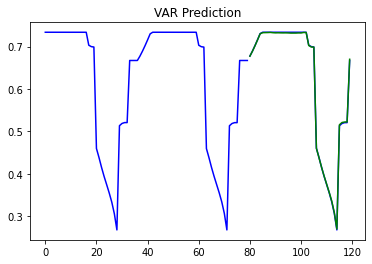

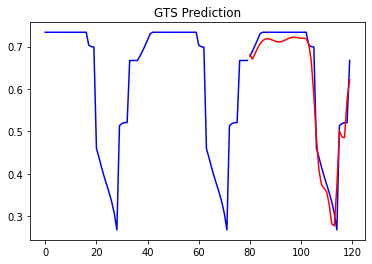

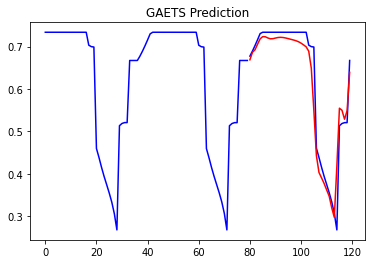

1


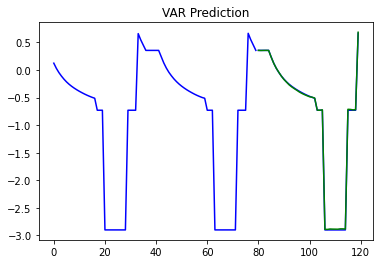

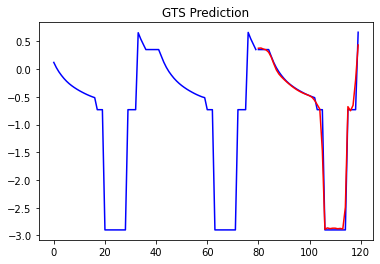

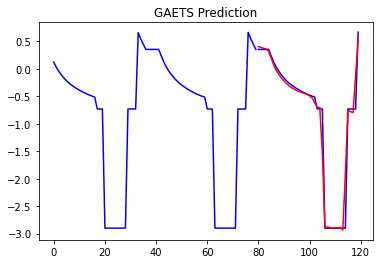

2


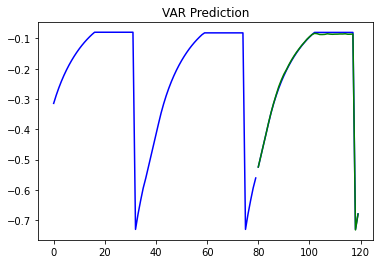

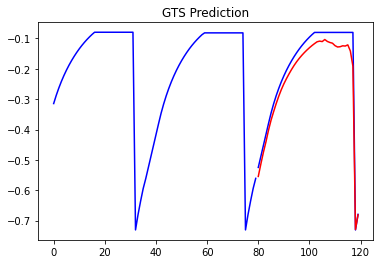

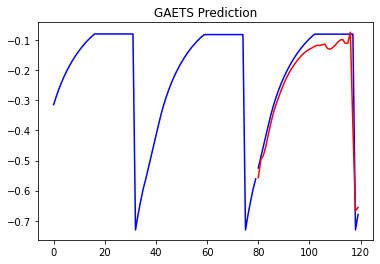

3


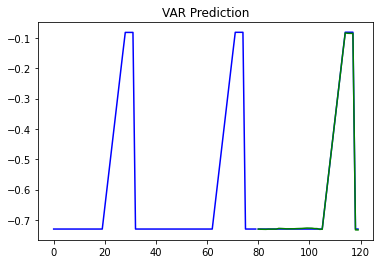

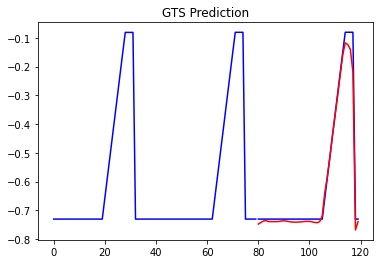

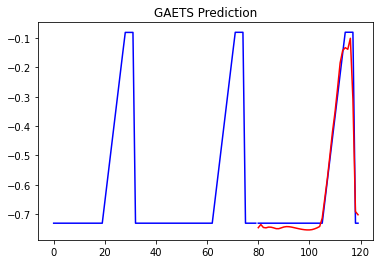

4


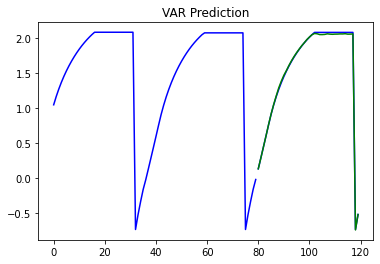

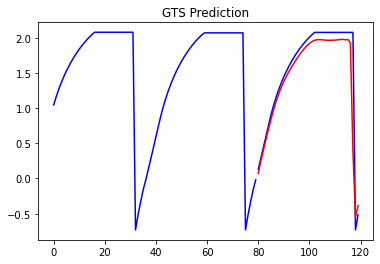

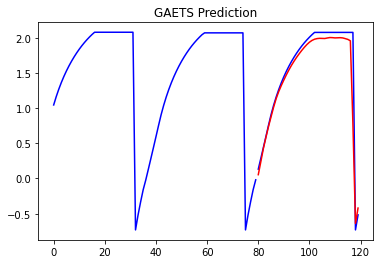

5


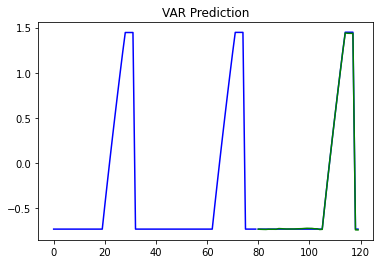

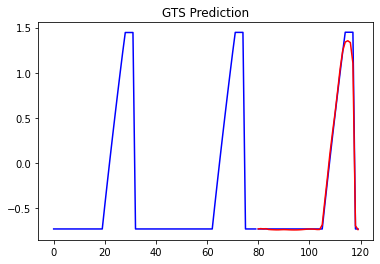

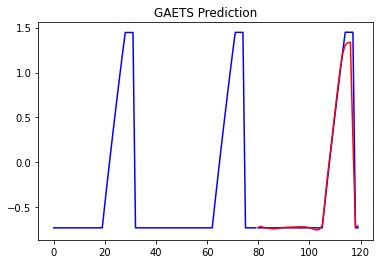

In [ ]:
# visualise result
"""
VISUALISE
"""

# get largest epoch
files = os.listdir("models/GTS")
largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
files = os.listdir("models/GAETS")
largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# Load Model
supervisor_gts._epoch_num = largestGTSEpoch
supervisor_gts.load_model()
supervisor_gaets._epoch_num = largestGAETSEpoch
supervisor_gaets.load_model()
label = "with_regularization"
temp_gts = supervisor_gts.temperature
temp_gaets = supervisor_gaets.temperature
gumbel_soft = True
batches_seen = 1

# get test data from unseen dataset
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gaets_prediction = output[:, i, :].cpu().numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

    # break
  break



""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gts_prediction = output[:, i, :].cpu().numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

    # break

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    input = x[:, i, :].cpu().numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 40)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)

    # break
  break

# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

## debug visualise

In [ ]:
# remove model
!rm models/GTS/*
!rm models/GAETS/*

rm: cannot remove 'models/GTS/*': No such file or directory
rm: cannot remove 'models/GAETS/*': No such file or directory


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model and test dataset
args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
with open(args.config_filename) as f:
    # supervisor_config["train"]["save_model"] = 0
    supervisor_config["train"]["epochs"] = 20
    save_adj_name = args.config_filename[11:-5]
    supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    supervisor_gts.GTS_model.use_curriculum_learning = False
    supervisor_gts.train()
    supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    supervisor_gaets.GTS_model.use_curriculum_learning = False
    supervisor_gaets.train()

2021-09-27 14:07:28,585 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927140728/
2021-09-27 14:07:28,585 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927140728/
2021-09-27 14:07:28,724 - INFO - Model created
2021-09-27 14:07:28,724 - INFO - Model created


testing loss,0.94258
training loss,0.41133
validation loss,0.84268


testing loss,█▁
training loss,█▆▅▄▄▄▃▂▁▁
validation loss,█▆▆▅▅▅▄▂▁▁


2021-09-27 14:07:39,841 - INFO - Start training ...
2021-09-27 14:07:39,841 - INFO - Start training ...
2021-09-27 14:07:39,852 - INFO - num_batches:24
2021-09-27 14:07:39,852 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 14:07:40,285 - INFO - Total trainable parameters 2596563
2021-09-27 14:07:40,285 - INFO - Total trainable parameters 2596563
2021-09-27 14:07:57,922 - INFO - epoch complete
2021-09-27 14:07:57,922 - INFO - epoch complete
2021-09-27 14:07:57,934 - INFO - evaluating now!
2021-09-27 14:07:57,934 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 14:07:58,983 - INFO - Epoch [0/20] (24) train_mae: 2.3311, val_mae: 2.3057
2021-09-27 14:07:58,983 - INFO - Epoch [0/20] (24) train_mae: 2.3311, val_mae: 2.3057
Num of epoch: 1
2021-09-27 14:08:16,702 - INFO - epoch complete
2021-09-27 14:08:16,702 - INFO - epoch complete
2021-09-27 14:08:16,714 - INFO - evaluating now!
2021-09-27 14:08:16,714 - INFO - evaluating now!
2021-09-27 14:08:17,813 - INFO - Epoch [1/20] (48) train_mae: 1.8702, val_mae: 2.0696
2021-09-27 14:08:17,813 - INFO - Epoch [1/20] (48) train_mae: 1.8702, val_mae: 2.0696
Num of epoch: 2
2021-09-27 14:08:35,354 - INFO - epoch complete
2021-09-27 14:08:35,354 - INFO - epoch complete
2021-09-27 14:08:35,367 - INFO - evaluating now!
2021-09-27 14:08:35,367 - INFO - evaluating now!
2021-09-27 14:08:36,453 - INFO - Epoch [2/20] (72) train_mae: 1.5871, val_mae: 1.8792
2021-09-27 14:08:36,453 - INFO - Epoch [2/20] (72) train_mae: 1.5871, val_mae: 1.8792
Num of epoch: 3
2021-09-27 14:08:54,507 - INFO - epoch complete


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 14:09:34,207 - INFO - epoch complete
2021-09-27 14:09:34,207 - INFO - epoch complete
2021-09-27 14:09:34,217 - INFO - evaluating now!
2021-09-27 14:09:34,217 - INFO - evaluating now!
2021-09-27 14:09:35,299 - INFO - Epoch [5/20] (144) train_mae: 1.0692, val_mae: 1.4488
2021-09-27 14:09:35,299 - INFO - Epoch [5/20] (144) train_mae: 1.0692, val_mae: 1.4488
Num of epoch: 6
2021-09-27 14:09:53,441 - INFO - epoch complete
2021-09-27 14:09:53,441 - INFO - epoch complete
2021-09-27 14:09:53,451 - INFO - evaluating now!
2021-09-27 14:09:53,451 - INFO - evaluating now!
2021-09-27 14:09:54,519 - INFO - Epoch [6/20] (168) train_mae: 0.8666, val_mae: 1.4218
2021-09-27 14:09:54,519 - INFO - Epoch [6/20] (168) train_mae: 0.8666, val_mae: 1.4218
Num of epoch: 7
2021-09-27 14:10:11,808 - INFO - epoch complete
2021-09-27 14:10:11,808 - INFO - epoch complete
2021-09-27 14:10:11,818 - INFO - evaluating now!
2021-09-27 14:10:11,818 - INFO - evaluating now!
2021-09-27 14:10:12,863 - INFO - Epoch

testing loss,0.89787
training loss,0.22829
validation loss,0.7949


testing loss,█▆▃▁
training loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
validation loss,█▇▆▆▅▄▄▄▄▄▂▂▂▃▃▁▁▁▁▁


2021-09-27 14:14:14,241 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927141414/
2021-09-27 14:14:14,241 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927141414/
2021-09-27 14:14:14,241 - INFO - Log directory: data/model/GAETS_DR_2_h_40_64_lr_0.005_bs_64_0927141414/
2021-09-27 14:14:14,416 - INFO - Model created
2021-09-27 14:14:14,416 - INFO - Model created
2021-09-27 14:14:14,416 - INFO - Model created


2021-09-27 14:14:21,839 - INFO - Start training ...
2021-09-27 14:14:21,839 - INFO - Start training ...
2021-09-27 14:14:21,839 - INFO - Start training ...
2021-09-27 14:14:21,845 - INFO - num_batches:24
2021-09-27 14:14:21,845 - INFO - num_batches:24
2021-09-27 14:14:21,845 - INFO - num_batches:24
Num of epoch: 0
2021-09-27 14:14:22,313 - INFO - Total trainable parameters 5570327
2021-09-27 14:14:22,313 - INFO - Total trainable parameters 5570327
2021-09-27 14:14:22,313 - INFO - Total trainable parameters 5570327
2021-09-27 14:14:39,639 - INFO - epoch complete
2021-09-27 14:14:39,639 - INFO - epoch complete
2021-09-27 14:14:39,639 - INFO - epoch complete
2021-09-27 14:14:39,650 - INFO - evaluating now!
2021-09-27 14:14:39,650 - INFO - evaluating now!
2021-09-27 14:14:39,650 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 14:14:40,704 - INFO - Epoch [0/20] (24) train_mae: 3.6083, val_mae: 3.2301
2021-09-27 14:14:40,704 - INFO - Epoch [0/20] (24) train_mae: 3.6083, val_mae: 3.2301
2021-09-27 14:14:40,704 - INFO - Epoch [0/20] (24) train_mae: 3.6083, val_mae: 3.2301
Num of epoch: 1
2021-09-27 14:14:57,783 - INFO - epoch complete
2021-09-27 14:14:57,783 - INFO - epoch complete
2021-09-27 14:14:57,783 - INFO - epoch complete
2021-09-27 14:14:57,799 - INFO - evaluating now!
2021-09-27 14:14:57,799 - INFO - evaluating now!
2021-09-27 14:14:57,799 - INFO - evaluating now!
2021-09-27 14:14:58,856 - INFO - Epoch [1/20] (48) train_mae: 3.1372, val_mae: 2.9849
2021-09-27 14:14:58,856 - INFO - Epoch [1/20] (48) train_mae: 3.1372, val_mae: 2.9849
2021-09-27 14:14:58,856 - INFO - Epoch [1/20] (48) train_mae: 3.1372, val_mae: 2.9849
Num of epoch: 2
2021-09-27 14:15:16,648 - INFO - epoch complete
2021-09-27 14:15:16,648 - INFO - epoch complete
2021-09-27 14:15:16,648 - INFO - epoch complete
2021-09-27 14:15:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 14:16:13,634 - INFO - epoch complete
2021-09-27 14:16:13,634 - INFO - epoch complete
2021-09-27 14:16:13,634 - INFO - epoch complete
2021-09-27 14:16:13,648 - INFO - evaluating now!
2021-09-27 14:16:13,648 - INFO - evaluating now!
2021-09-27 14:16:13,648 - INFO - evaluating now!
2021-09-27 14:16:14,703 - INFO - Epoch [5/20] (144) train_mae: 1.2207, val_mae: 1.2844
2021-09-27 14:16:14,703 - INFO - Epoch [5/20] (144) train_mae: 1.2207, val_mae: 1.2844
2021-09-27 14:16:14,703 - INFO - Epoch [5/20] (144) train_mae: 1.2207, val_mae: 1.2844
Num of epoch: 6
2021-09-27 14:16:32,280 - INFO - epoch complete
2021-09-27 14:16:32,280 - INFO - epoch complete
2021-09-27 14:16:32,280 - INFO - epoch complete
2021-09-27 14:16:32,288 - INFO - evaluating now!
2021-09-27 14:16:32,288 - INFO - evaluating now!
2021-09-27 14:16:32,288 - INFO - evaluating now!
2021-09-27 14:16:33,360 - INFO - Epoch [6/20] (168) train_mae: 0.8138, val_mae: 1.0712
2021-09-27 14:16:33,360 - INFO - Epoch [6/20] (168) tr

testing loss,0.43374
training loss,0.27292
validation loss,0.31717


testing loss,█▂▄▁
training loss,█▇▆▅▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▄▃▃▂▂▂▂▁▂▃▂▁▁▁▁▁


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0


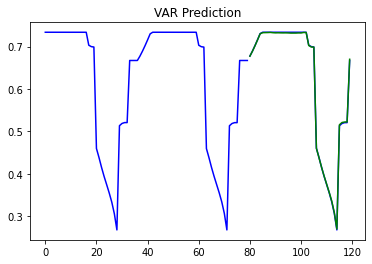

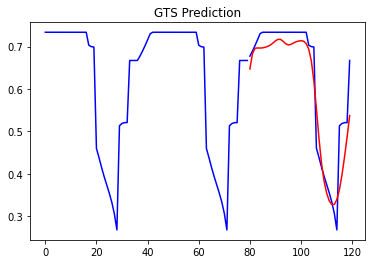

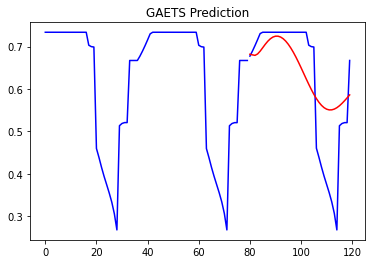

1


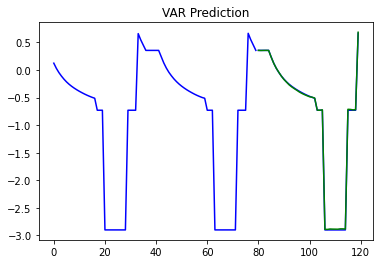

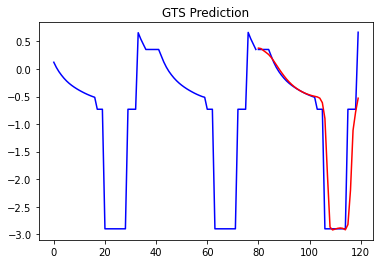

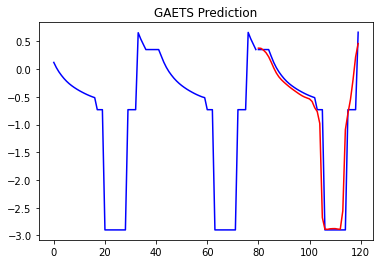

2


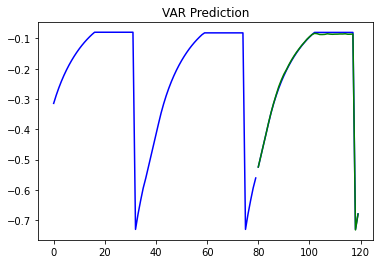

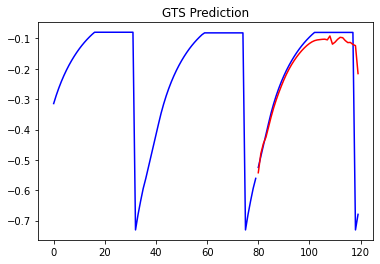

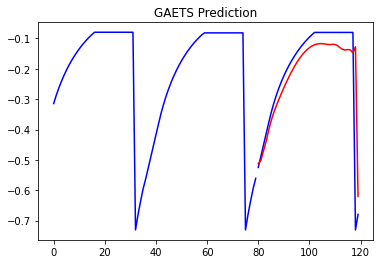

3


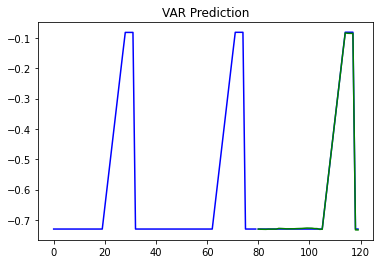

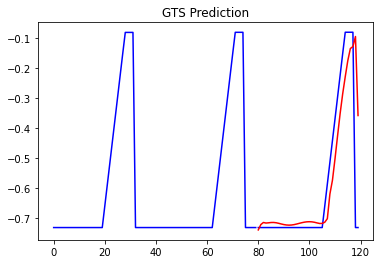

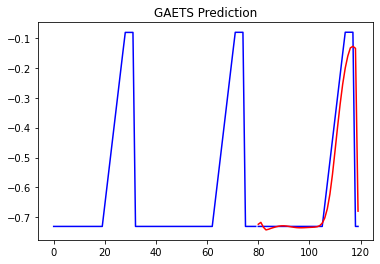

4


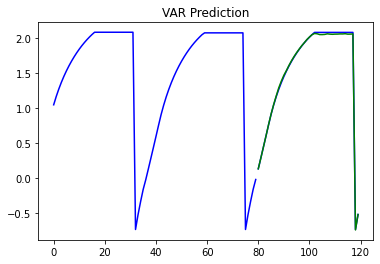

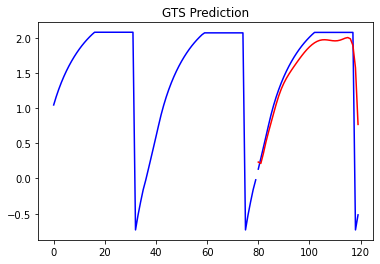

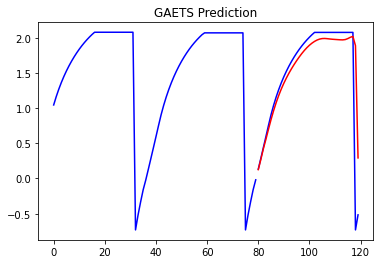

5


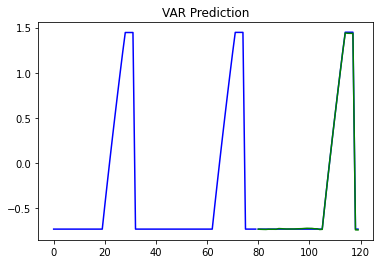

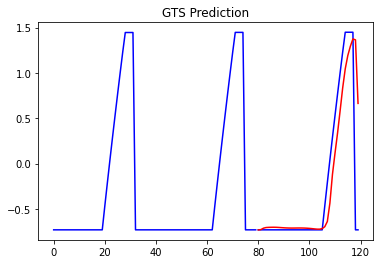

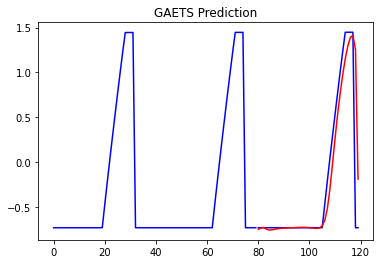

In [ ]:
"""
VISUALISE
"""

# # get largest epoch
# files = os.listdir("models/GTS")
# largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
# files = os.listdir("models/GAETS")
# largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
# print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# # Load Model
# supervisor_gts._epoch_num = largestGTSEpoch
# supervisor_gts.load_model()
# supervisor_gaets._epoch_num = largestGAETSEpoch
# supervisor_gaets.load_model()
label = "with_regularization"
temp_gts = supervisor_gts.temperature
temp_gaets = supervisor_gaets.temperature
gumbel_soft = True
batches_seen = 1

# get test data from unseen dataset
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  # supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gaets_prediction = output[:, i, :].cpu().numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

    # break
  break



""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  # supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gts_prediction = output[:, i, :].cpu().numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

    # break

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    input = x[:, i, :].cpu().numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 40)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)

    # break
  break

# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

In [ ]:
scoreMedianDict = {
  "GAETS": {
      "RMSE": np.median(gaets_rmses), 
      "MAPE": np.median(gaets_mapes), 
      "MAE": np.median(gaets_maes), 
      "RMS data points": len(gaets_rmses), 
      "MAPE data points": len(gaets_mapes), 
      "MAE data points": len(gaets_maes),
      # "Best Epoch": largestGAETSEpoch
  },
  "GTS": {
      "RMSE": np.median(gts_rmses), 
      "MAPE": np.median(gts_mapes), 
      "MAE": np.median(gts_maes), 
      "RMS data points": len(gts_rmses), 
      "MAPE data points": len(gts_mapes), 
      "MAE data points": len(gts_maes),
      # "Best Epoch": largestGTSEpoch
  },
  "VAR": {
      "RMSE": np.median(var_rmses), 
      "MAPE": np.median(var_mapes), 
      "MAE": np.median(var_maes), 
      "RMS data points": len(var_rmses), 
      "MAPE data points": len(var_mapes), 
      "MAE data points": len(var_maes),
      # "Best Epoch": -1
  },
}
scoreMedianDict

{'GAETS': {'MAE': 0.06394073,
  'MAE data points': 64,
  'MAPE': 0.208021,
  'MAPE data points': 64,
  'RMS data points': 64,
  'RMSE': 0.16299915},
 'GTS': {'MAE': 0.08701189,
  'MAE data points': 64,
  'MAPE': 0.22473338,
  'MAPE data points': 64,
  'RMS data points': 64,
  'RMSE': 0.22769472},
 'VAR': {'MAE': 0.0022154273,
  'MAE data points': 64,
  'MAPE': 0.00909565,
  'MAPE data points': 64,
  'RMS data points': 64,
  'RMSE': 0.0032829843}}